# Minute-Level Analysis: Garmin Health + RouterSense Network Data

**Objective:** Analyze minute-by-minute correlations between phone usage and physiological responses

**Data:**
- Garmin: Heart rate, stress level, body battery (minute-level)
- RouterSense: Network connections (aggregated to minute-level)
- Date: November 18, 2025

**Analysis:**
1. Load and consolidate minute-level Garmin data
2. Aggregate RouterSense to minute-level
3. Merge datasets
4. Analyze correlations and patterns

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries loaded")

✓ Libraries loaded


## 2. Load Garmin Minute-Level Data

In [2]:
# Load minute-level health data
garmin_raw = pd.read_csv('../output/garmin_parsed/garmin_minute_health.csv')
garmin_raw['datetime'] = pd.to_datetime(garmin_raw['datetime'])

print(f"📊 Raw Garmin Data Loaded")
print(f"   Records: {len(garmin_raw):,}")
print(f"   Time range (UTC): {garmin_raw['datetime'].min()} to {garmin_raw['datetime'].max()}")
print(f"\n   Coverage:")
print(f"   - Heart Rate: {(garmin_raw['heart_rate'].notna().sum() / len(garmin_raw) * 100):.1f}%")
print(f"   - Stress: {(garmin_raw['stress_level'].notna().sum() / len(garmin_raw) * 100):.1f}%")
print(f"   - Body Battery: {(garmin_raw['body_battery'].notna().sum() / len(garmin_raw) * 100):.1f}%")

garmin_raw.head(10)

📊 Raw Garmin Data Loaded
   Records: 3,179
   Time range (UTC): 2025-11-18 05:00:00+00:00 to 2025-11-19 05:00:00+00:00

   Coverage:
   - Heart Rate: 36.8%
   - Stress: 44.3%
   - Body Battery: 45.2%


,datetime,heart_rate,stress_level,body_battery
0,2025-11-18 05:00:00+00:00,NaN,NaN,NaN
1,2025-11-18 05:00:00+00:00,NaN,NaN,NaN
2,2025-11-18 05:01:00+00:00,NaN,NaN,NaN
3,2025-11-18 05:01:00+00:00,NaN,34.0,18.0
4,2025-11-18 05:02:00+00:00,89.0,NaN,NaN
5,2025-11-18 05:02:00+00:00,NaN,61.0,18.0
6,2025-11-18 05:03:00+00:00,99.0,NaN,NaN
7,2025-11-18 05:03:00+00:00,NaN,NaN,NaN
8,2025-11-18 05:03:00+00:00,NaN,65534.0,18.0
9,2025-11-18 05:04:00+00:00,93.0,NaN,NaN


## 3. Consolidate Duplicate Timestamps & Convert to Local Time

Since heart rate and stress/body battery come from different arrays, we have duplicate timestamps. Let's consolidate them and convert from UTC to EST to match RouterSense local time.

In [3]:
# Consolidate duplicates - take first non-null value for each metric
garmin_minute = garmin_raw.groupby('datetime').agg({
    'heart_rate': lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else np.nan,
    'stress_level': lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else np.nan,
    'body_battery': lambda x: x.dropna().iloc[0] if len(x.dropna()) > 0 else np.nan
}).reset_index()

# Convert UTC to EST (UTC-5) to match RouterSense local time
garmin_minute['datetime'] = garmin_minute['datetime'].dt.tz_convert('America/New_York').dt.tz_localize(None)

print(f"✓ Consolidated to {len(garmin_minute):,} unique minutes")
print(f"   Time range (EST): {garmin_minute['datetime'].min()} to {garmin_minute['datetime'].max()}")
print(f"\n   Coverage after consolidation:")
print(f"   - Heart Rate: {(garmin_minute['heart_rate'].notna().sum() / len(garmin_minute) * 100):.1f}%")
print(f"   - Stress: {(garmin_minute['stress_level'].notna().sum() / len(garmin_minute) * 100):.1f}%")
print(f"   - Body Battery: {(garmin_minute['body_battery'].notna().sum() / len(garmin_minute) * 100):.1f}%")

garmin_minute.head(10)

✓ Consolidated to 1,440 unique minutes
   Time range (EST): 2025-11-18 00:00:00 to 2025-11-19 00:00:00

   Coverage after consolidation:
   - Heart Rate: 81.2%
   - Stress: 97.8%
   - Body Battery: 99.9%


,datetime,heart_rate,stress_level,body_battery
0,2025-11-18 00:00:00,NaN,NaN,NaN
1,2025-11-18 00:01:00,NaN,34.0,18.0
2,2025-11-18 00:02:00,89.0,61.0,18.0
3,2025-11-18 00:03:00,99.0,65534.0,18.0
4,2025-11-18 00:04:00,93.0,NaN,18.0
5,2025-11-18 00:05:00,78.0,NaN,18.0
6,2025-11-18 00:06:00,77.0,22.0,18.0
7,2025-11-18 00:07:00,73.0,23.0,18.0
8,2025-11-18 00:08:00,74.0,20.0,18.0
9,2025-11-18 00:09:00,NaN,17.0,18.0


## 4. Load RouterSense Data

In [12]:
# Load RouterSense data
phone_data = pd.read_csv('../data/phone_overall_activities.csv')

# Convert Unix timestamp to datetime (local time)
phone_data['timestamp'] = pd.to_datetime(phone_data['timestamp'], unit='s')

# Parse metadata
def parse_metadata(metadata_str):
    try:
        return json.loads(metadata_str) if pd.notna(metadata_str) else {}
    except:
        return {}

phone_data['metadata_dict'] = phone_data['metadata_json'].apply(parse_metadata)
phone_data['domain'] = phone_data['metadata_dict'].apply(lambda x: x.get('registered_domain', 'unknown'))
phone_data['app'] = phone_data['metadata_dict'].apply(lambda x: x.get('entity_name', 'unknown'))

print(f"📊 RouterSense Data Loaded")
print(f"   Total records: {len(phone_data):,}")
print(f"   Time range: {phone_data['timestamp'].min()} to {phone_data['timestamp'].max()}")

📊 RouterSense Data Loaded
   Total records: 432,291
   Time range: 2025-10-27 05:39:00 to 2025-12-03 18:02:50


## 5. Filter for November 18, 2025

In [13]:
# Filter for November 18, 2025
target_date = pd.to_datetime('2025-11-18')
phone_nov18 = phone_data[
    (phone_data['timestamp'].dt.date == target_date.date())
].copy()

print(f"📅 Filtered for November 18, 2025")
print(f"   Records: {len(phone_nov18):,}")
print(f"   Time range: {phone_nov18['timestamp'].min()} to {phone_nov18['timestamp'].max()}")
total_bytes = phone_nov18['upload_byte_count'].sum() + phone_nov18['download_byte_count'].sum()
print(f"   Total data: {total_bytes / (1024*1024):.2f} MB")

📅 Filtered for November 18, 2025
   Records: 12,027
   Time range: 2025-11-18 00:01:00 to 2025-11-18 23:59:50
   Total data: 3581.68 MB


## 6. Aggregate RouterSense to Minute-Level

In [14]:
# Aggregate to minute-level
phone_minute = phone_nov18.groupby(pd.Grouper(key='timestamp', freq='1min')).agg({
    'upload_byte_count': 'sum',
    'download_byte_count': 'sum',
    'upload_packet_count': 'sum',
    'download_packet_count': 'sum',
    'domain': 'count',  # Number of connections
    'app': lambda x: x.nunique()  # Unique apps
}).reset_index()

# Rename and convert bytes to MB
phone_minute.columns = ['datetime', 'upload_bytes', 'download_bytes', 'upload_packets', 'download_packets', 'connection_count', 'unique_apps']
phone_minute['upload_mb'] = phone_minute['upload_bytes'] / (1024 * 1024)
phone_minute['download_mb'] = phone_minute['download_bytes'] / (1024 * 1024)
phone_minute['total_mb'] = phone_minute['upload_mb'] + phone_minute['download_mb']

print(f"✓ Aggregated RouterSense to minute-level")
print(f"   Minutes with data: {len(phone_minute[phone_minute['connection_count'] > 0]):,}")
print(f"   Total connections: {phone_minute['connection_count'].sum():,}")
print(f"   Total data: {phone_minute['total_mb'].sum():.2f} MB")

phone_minute.head(10)

✓ Aggregated RouterSense to minute-level
   Minutes with data: 965
   Total connections: 12,027
   Total data: 3581.68 MB


,datetime,upload_bytes,download_bytes,upload_packets,download_packets,connection_count,unique_apps,upload_mb,download_mb,total_mb
0,2025-11-18 00:01:00,55586,93239,94,82,9,2,0.053011,0.088920,0.141931
1,2025-11-18 00:02:00,384,120,6,3,2,1,0.000366,0.000114,0.000481
2,2025-11-18 00:03:00,0,0,0,0,0,0,0.000000,0.000000,0.000000
3,2025-11-18 00:04:00,0,0,0,0,0,0,0.000000,0.000000,0.000000
4,2025-11-18 00:05:00,0,0,0,0,0,0,0.000000,0.000000,0.000000
5,2025-11-18 00:06:00,0,0,0,0,0,0,0.000000,0.000000,0.000000
6,2025-11-18 00:07:00,0,0,0,0,0,0,0.000000,0.000000,0.000000
7,2025-11-18 00:08:00,80,204,1,3,1,1,0.000076,0.000195,0.000271
8,2025-11-18 00:09:00,0,0,0,0,0,0,0.000000,0.000000,0.000000
9,2025-11-18 00:10:00,6506,5988,14,10,2,2,0.006205,0.005711,0.011915


## 7. Merge Garmin + RouterSense (Minute-Level)

In [15]:
# Merge on datetime (both are now timezone-naive and in EST)
combined_minute = garmin_minute.merge(phone_minute, on='datetime', how='outer')

# Fill NaN for network metrics with 0 (no activity)
combined_minute[['total_mb', 'upload_mb', 'download_mb', 'connection_count', 'unique_apps']] = \
    combined_minute[['total_mb', 'upload_mb', 'download_mb', 'connection_count', 'unique_apps']].fillna(0)

# Add time features
combined_minute['hour'] = combined_minute['datetime'].dt.hour
combined_minute['minute'] = combined_minute['datetime'].dt.minute
combined_minute['day_of_week'] = combined_minute['datetime'].dt.dayofweek

# Sort by datetime
combined_minute = combined_minute.sort_values('datetime').reset_index(drop=True)

print(f"🔗 Merged Minute-Level Dataset Created")
print(f"   Total minutes: {len(combined_minute):,}")
print(f"   Date: {combined_minute['datetime'].dt.date.unique()}")
print(f"\n📊 Data Summary:")
print(f"   Minutes with HR data: {combined_minute['heart_rate'].notna().sum():,}")
print(f"   Minutes with stress data: {combined_minute['stress_level'].notna().sum():,}")
print(f"   Minutes with network activity: {(combined_minute['connection_count'] > 0).sum():,}")

combined_minute.head(20)

🔗 Merged Minute-Level Dataset Created
   Total minutes: 1,441
   Date: [datetime.date(2025, 11, 18) datetime.date(2025, 11, 19)]

📊 Data Summary:
   Minutes with HR data: 1,170
   Minutes with stress data: 1,409
   Minutes with network activity: 965


,datetime,heart_rate,stress_level,body_battery,upload_bytes,download_bytes,upload_packets,download_packets,connection_count,unique_apps,upload_mb,download_mb,total_mb,hour,minute,day_of_week
0,2025-11-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,0.000000,0.000000,0,0,1
1,2025-11-18 00:01:00,NaN,34.0,18.0,55586.0,93239.0,94.0,82.0,9.0,2.0,0.053011,0.088920,0.141931,0,1,1
2,2025-11-18 00:02:00,89.0,61.0,18.0,384.0,120.0,6.0,3.0,2.0,1.0,0.000366,0.000114,0.000481,0,2,1
3,2025-11-18 00:03:00,99.0,65534.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,3,1
4,2025-11-18 00:04:00,93.0,NaN,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,4,1
5,2025-11-18 00:05:00,78.0,NaN,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,5,1
6,2025-11-18 00:06:00,77.0,22.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,6,1
7,2025-11-18 00:07:00,73.0,23.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,7,1
8,2025-11-18 00:08:00,74.0,20.0,18.0,80.0,204.0,1.0,3.0,1.0,1.0,0.000076,0.000195,0.000271,0,8,1
9,2025-11-18 00:09:00,NaN,17.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,9,1


In [16]:
# Check data quality
print("📊 Data Quality Summary\n")
print(combined_minute.describe())

📊 Data Quality Summary

                  datetime   heart_rate  stress_level  body_battery  \
count                 1441  1170.000000   1409.000000   1438.000000   
mean   2025-11-18 12:00:00    86.449573   9706.095103     26.550070   
min    2025-11-18 00:00:00    62.000000      1.000000      5.000000   
25%    2025-11-18 06:00:00    77.000000     22.000000     13.000000   
50%    2025-11-18 12:00:00    84.000000     38.000000     21.000000   
75%    2025-11-18 18:00:00    94.000000     69.000000     41.000000   
max    2025-11-19 00:00:00   139.000000  65534.000000     61.000000   
std                    NaN    14.206154  23241.590148     17.015117   

       upload_bytes  download_bytes  upload_packets  download_packets  \
count  1.439000e+03    1.439000e+03     1439.000000       1439.000000   
mean   2.691879e+05    2.340724e+06      515.856845        510.279361   
min    0.000000e+00    0.000000e+00        0.000000          0.000000   
25%    0.000000e+00    0.000000e+00        0

## 8. Time Series Visualization

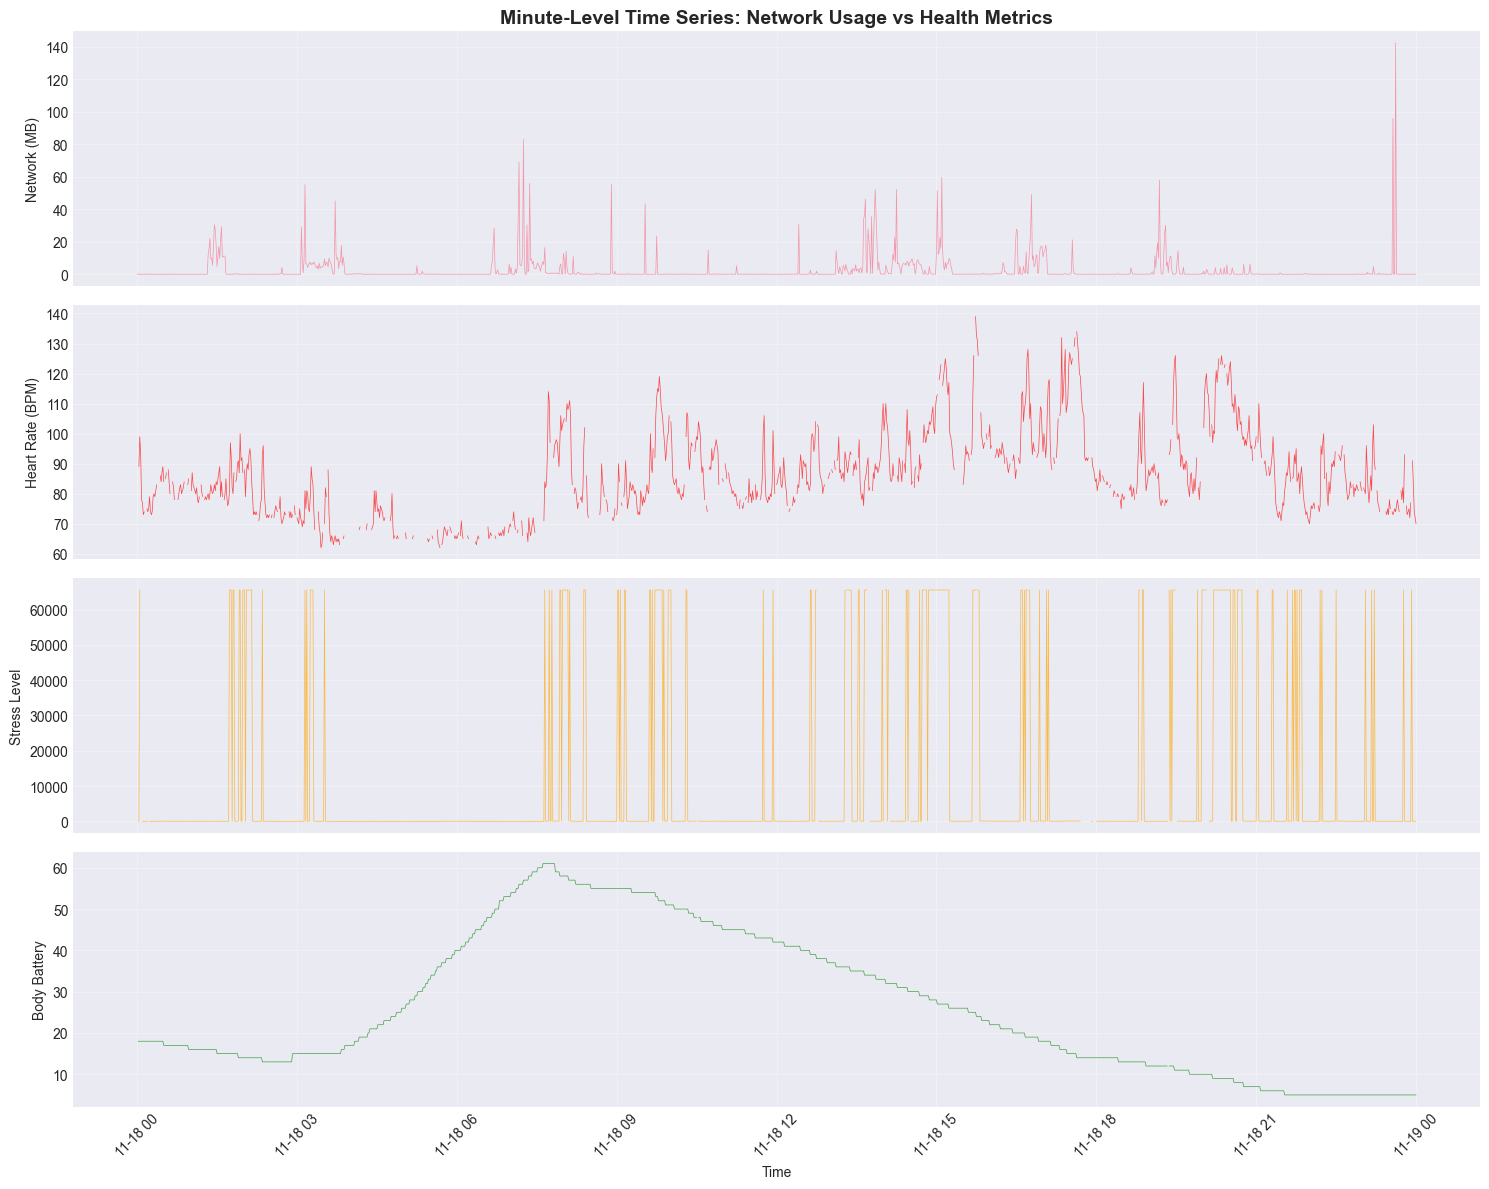

✓ Time series visualized


In [17]:
# Plot minute-level time series
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Network usage
axes[0].plot(combined_minute['datetime'], combined_minute['total_mb'], linewidth=0.5, alpha=0.7)
axes[0].set_ylabel('Network (MB)', fontsize=10)
axes[0].set_title('Minute-Level Time Series: Network Usage vs Health Metrics', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Heart rate
axes[1].plot(combined_minute['datetime'], combined_minute['heart_rate'], color='red', linewidth=0.5, alpha=0.7)
axes[1].set_ylabel('Heart Rate (BPM)', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Stress level
axes[2].plot(combined_minute['datetime'], combined_minute['stress_level'], color='orange', linewidth=0.5, alpha=0.7)
axes[2].set_ylabel('Stress Level', fontsize=10)
axes[2].grid(True, alpha=0.3)

# Body battery
axes[3].plot(combined_minute['datetime'], combined_minute['body_battery'], color='green', linewidth=0.5, alpha=0.7)
axes[3].set_ylabel('Body Battery', fontsize=10)
axes[3].set_xlabel('Time', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Time series visualized")

## 9. Correlation Analysis (Minute-Level)

📊 Correlation Analysis
   Minutes with complete data: 1,141


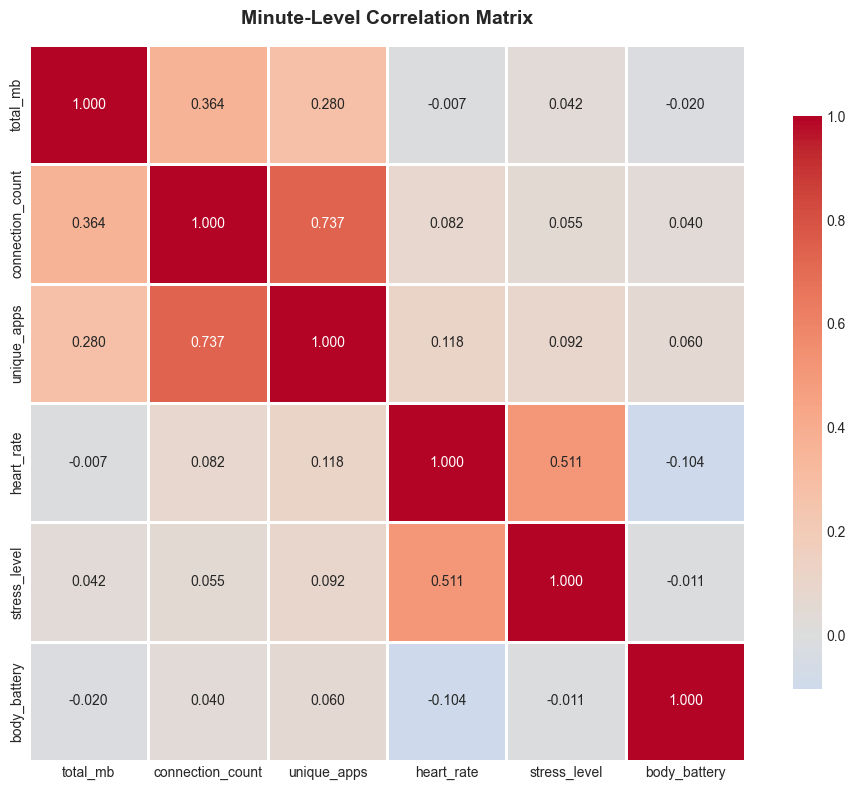


🔍 Key Correlations with Network Usage:
total_mb            1.000000
connection_count    0.364469
unique_apps         0.279672
stress_level        0.041839
heart_rate         -0.006682
body_battery       -0.019586
Name: total_mb, dtype: float64


In [18]:
# Calculate correlations (only for minutes with data)
corr_data = combined_minute[[
    'total_mb', 'connection_count', 'unique_apps',
    'heart_rate', 'stress_level', 'body_battery'
]].dropna()

print(f"📊 Correlation Analysis")
print(f"   Minutes with complete data: {len(corr_data):,}")

if len(corr_data) > 10:
    corr_matrix = corr_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Minute-Level Correlation Matrix', fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()
    
    print("\n🔍 Key Correlations with Network Usage:")
    print(corr_matrix['total_mb'].sort_values(ascending=False))
else:
    print("⚠️  Not enough complete data points for correlation analysis")

## 10. Scatter Plots (Minute-Level)

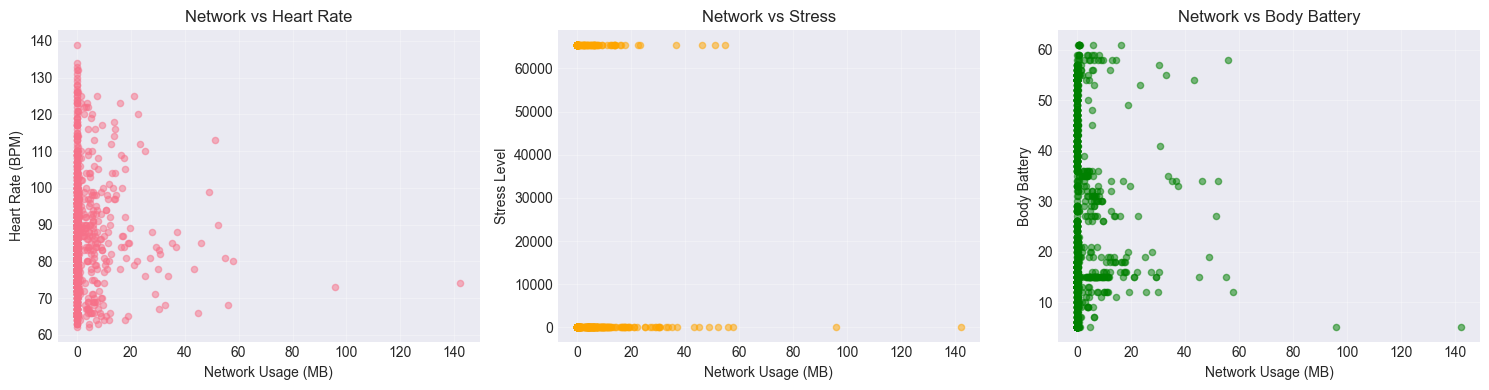

✓ Scatter plots generated


In [19]:
# Create scatter plots for minutes with data
plot_data = combined_minute.dropna(subset=['heart_rate', 'stress_level', 'body_battery'])

if len(plot_data) > 10:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Network vs Heart Rate
    axes[0].scatter(plot_data['total_mb'], plot_data['heart_rate'], alpha=0.5, s=20)
    axes[0].set_xlabel('Network Usage (MB)')
    axes[0].set_ylabel('Heart Rate (BPM)')
    axes[0].set_title('Network vs Heart Rate')
    axes[0].grid(True, alpha=0.3)
    
    # Network vs Stress
    axes[1].scatter(plot_data['total_mb'], plot_data['stress_level'], alpha=0.5, s=20, color='orange')
    axes[1].set_xlabel('Network Usage (MB)')
    axes[1].set_ylabel('Stress Level')
    axes[1].set_title('Network vs Stress')
    axes[1].grid(True, alpha=0.3)
    
    # Network vs Body Battery
    axes[2].scatter(plot_data['total_mb'], plot_data['body_battery'], alpha=0.5, s=20, color='green')
    axes[2].set_xlabel('Network Usage (MB)')
    axes[2].set_ylabel('Body Battery')
    axes[2].set_title('Network vs Body Battery')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Scatter plots generated")
else:
    print("⚠️  Not enough data points for scatter plots")

## 11. Save Minute-Level Dataset

In [20]:
# Create output directory if it doesn't exist
import os
os.makedirs('../output/analysis_results', exist_ok=True)

# Save combined minute-level dataset
output_path = '../output/analysis_results/combined_minute_level_nov18.csv'
combined_minute.to_csv(output_path, index=False)

print(f"✓ Minute-level dataset saved to: {output_path}")
print(f"   Records: {len(combined_minute):,}")
print(f"   Columns: {len(combined_minute.columns)}")

✓ Minute-level dataset saved to: ../output/analysis_results/combined_minute_level_nov18.csv
   Records: 1,441
   Columns: 16


## 12. Summary Statistics

In [21]:
print("📊 MINUTE-LEVEL SUMMARY\n")
print("=" * 70)

print("\n🌐 Network Activity:")
print(f"   Total data: {combined_minute['total_mb'].sum():.2f} MB")
print(f"   Minutes with activity: {(combined_minute['connection_count'] > 0).sum():,}")
print(f"   Total connections: {combined_minute['connection_count'].sum():,.0f}")
print(f"   Peak minute: {combined_minute.loc[combined_minute['total_mb'].idxmax(), 'datetime']}")
print(f"   Peak usage: {combined_minute['total_mb'].max():.3f} MB")

print("\n❤️  Heart Rate:")
hr_data = combined_minute['heart_rate'].dropna()
print(f"   Minutes with data: {len(hr_data):,}")
print(f"   Average: {hr_data.mean():.1f} BPM")
print(f"   Range: {hr_data.min():.0f} - {hr_data.max():.0f} BPM")

print("\n😰 Stress Level:")
stress_data = combined_minute['stress_level'].dropna()
print(f"   Minutes with data: {len(stress_data):,}")
print(f"   Average: {stress_data.mean():.1f}")
print(f"   Range: {stress_data.min():.0f} - {stress_data.max():.0f}")

print("\n🔋 Body Battery:")
battery_data = combined_minute['body_battery'].dropna()
print(f"   Minutes with data: {len(battery_data):,}")
print(f"   Average: {battery_data.mean():.1f}")
print(f"   Range: {battery_data.min():.0f} - {battery_data.max():.0f}")

print("\n" + "=" * 70)

📊 MINUTE-LEVEL SUMMARY


🌐 Network Activity:
   Total data: 3581.68 MB
   Minutes with activity: 965
   Total connections: 12,027
   Peak minute: 2025-11-18 23:37:00
   Peak usage: 142.277 MB

❤️  Heart Rate:
   Minutes with data: 1,170
   Average: 86.4 BPM
   Range: 62 - 139 BPM

😰 Stress Level:
   Minutes with data: 1,409
   Average: 9706.1
   Range: 1 - 65534

🔋 Body Battery:
   Minutes with data: 1,438
   Average: 26.6
   Range: 5 - 61

